In [1]:
%%capture --no-stderr
%pip install python-dotenv langchain langchain-community langchain-experimental langchain-openai networkx matplotlib

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os
#from langchain_google_vertexai import VertexAI 
#from langchain.llms import OpenAI
from langchain_openai import ChatOpenAI

#llm = VertexAI(max_output_tokens=4000,model_name='text-bison-32k')
#llm = ChatOpenAI(model="gpt-4o")  # 또는 gpt-4 등 사용할 모델명 지정
llm = ChatOpenAI(model=os.getenv("OPENAI_API_MODEL"))  # 또는 gpt-4 등 사용할 모델명 지정


In [4]:
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer

text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris. 
"""

documents = [Document(page_content=text)]
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents)

llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)


In [5]:
from langchain_community.graphs import NetworkxEntityGraph

graph = NetworkxEntityGraph()

# Add nodes to the graph
for node in graph_documents_filtered[0].nodes:
    print(f"* CREATE (:{node.type} {node.model_dump_json()})")
    graph.add_node(node.id)

# Add edges to the graph
for edge in graph_documents_filtered[0].relationships:
    print(f"* MERGE ({edge.source.id}) - [:{edge.type}] -> ({edge.target.id})")
    graph._graph.add_edge(
            edge.source.id,
            edge.target.id,
            relation=edge.type,
        )

* CREATE (:Person {"id":"Marie Curie","type":"Person","properties":{}})
* CREATE (:Person {"id":"Pierre Curie","type":"Person","properties":{}})
* CREATE (:Organization {"id":"University Of Paris","type":"Organization","properties":{}})
* CREATE (:Organization {"id":"Nobel Prize","type":"Organization","properties":{}})
* CREATE (:Country {"id":"Poland","type":"Country","properties":{}})
* CREATE (:Country {"id":"France","type":"Country","properties":{}})
* MERGE (Marie Curie) - [:WORKED_AT] -> (Nobel Prize)
* MERGE (Marie Curie) - [:WORKED_AT] -> (University Of Paris)
* MERGE (Marie Curie) - [:SPOUSE] -> (Pierre Curie)
* MERGE (Pierre Curie) - [:SPOUSE] -> (Marie Curie)
* MERGE (Marie Curie) - [:NATIONALITY] -> (Poland)
* MERGE (Marie Curie) - [:NATIONALITY] -> (France)
* MERGE (Marie Curie) - [:WORKED_AT] -> (Nobel Prize)


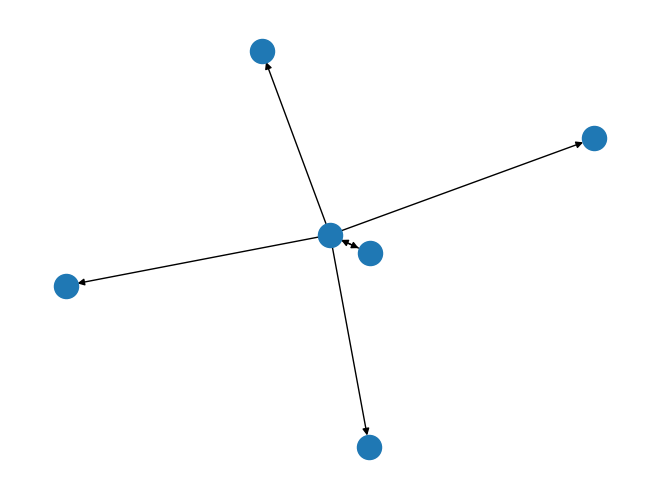

In [6]:
#from IPython.display import Image, display
#display(Image(graph.draw_mermaid_png()))

import networkx as nx
import matplotlib.pyplot as plt

g1 = graph._graph
nx.draw(g1)
plt.show()

In [7]:

from langchain.chains import GraphQAChain

chain = GraphQAChain.from_llm(
    llm=llm, 
    graph=graph, 
    verbose=True
)

question = """Who is Marie Curie?"""
result = chain.invoke(question)

print("답변:", result["result"])




> Entering new GraphQAChain chain...
Entities Extracted:
Marie Curie
Full Context:
Marie Curie WORKED_AT Nobel Prize
Marie Curie WORKED_AT University Of Paris
Marie Curie SPOUSE Pierre Curie
Marie Curie NATIONALITY Poland
Marie Curie NATIONALITY France

> Finished chain.
답변: Marie Curie was a Polish-French woman who worked at notable institutions such as the Nobel Prize and the University of Paris. She was married to Pierre Curie.
